In [1]:
import torch
import torch.nn as nn
import numpy as np

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
from models.model import MLP
from utils.losses import PartialLoss,EMLoss
from utils.trainig_testing import train_and_evaluate,warm_up

In [2]:
Data = Torch_Dataset('kmnist', batch_size=64)
Weak = Weakener(Data.num_classes)
#Weak.generate_M(model_class='pll')

100.0%


Extracting ./data\KMNIST\raw\train-images-idx3-ubyte.gz to ./data\KMNIST\raw



100.0%


Extracting ./data\KMNIST\raw\train-labels-idx1-ubyte.gz to ./data\KMNIST\raw



100.0%


Extracting ./data\KMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\KMNIST\raw



100.0%

Extracting ./data\KMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\KMNIST\raw



In [3]:
print('Methods for Data Class','\n',[method for method in dir(Data) if (method[0] != '_') & callable(getattr(Data, method)) ],'\n'
      'Instances for Data Class','\n',[method for method in dir(Data) if (method[0] != '_') & (method not in [method for method in dir(Data) if (method[0] != '_') & callable(getattr(Data, method)) ]) ],'\n\n'
      'Methods for Weak Class','\n',[method for method in dir(Weak) if (method[0] != '_') & callable(getattr(Weak, method)) ],'\n'
      'Instances for Weak Class','\n',[method for method in dir(Weak) if (method[0] != '_') & (method not in [method for method in dir(Weak) if (method[0] != '_') & callable(getattr(Weak, method)) ]) ])

Methods for Data Class 
 ['get_data', 'get_dataloader', 'include_weak', 'transform'] 
Instances for Data Class 
 ['batch_size', 'dataset', 'num_classes', 'num_features', 'shuffle', 'test_dataset', 'test_num_samples', 'train_dataset', 'train_num_samples', 'weak_labels'] 

Methods for Weak Class 
 ['generate_M', 'generate_weak', 'generate_wl_priors', 'label_matrix', 'pll_weights', 'virtual_labels', 'virtual_matrix'] 
Instances for Weak Class 
 ['M', 'c', 'd', 'w', 'z']


In [4]:
Weak.generate_M('pll',pll_p=0.5)
Weak.M[:5,:],Weak.Z[:5,:]

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00217014, 0.00217014],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00217014, 0.        , 0.00217014],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00217014, 0.00217014, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.00195312, 0.00195312, 0.00195312],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.00217014, 0.        , 0.        , 0.00217014]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1]]))

In [5]:
train_X,train_y,test_X,test_y =  Data.get_data()
print(train_X.shape)

torch.Size([60000, 784])


In [6]:
Weak.generate_weak(train_y)

(tensor([321, 437, 636,  ..., 892, 112, 393], dtype=torch.int32),
 tensor([[0., 1., 0.,  ..., 0., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 1.]], dtype=torch.float64))

In [7]:
train_y[:5,:],Weak.z[:5],Weak.w[:5,:]

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 tensor([321, 437, 636, 338, 240], dtype=torch.int32),
 tensor([[0., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
         [0., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 1., 0., 0., 1.]], dtype=torch.float64))

In [8]:
Data.include_weak(Weak.z)

In [9]:
trainloader,testloader = Data.get_dataloader()

In [10]:
print('Methods for MLP Class','\n',[method for method in dir(MLP) if (method[0] != '_') & callable(getattr(MLP, method)) ],'\n'
      'Instances for MLP Class','\n',[method for method in dir(MLP) if (method[0] != '_') & (method not in [method for method in dir(MLP) if (method[0] != '_') & callable(getattr(MLP, method))])])

Methods for MLP Class 
 ['add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'double', 'eval', 'extra_repr', 'float', 'forward', 'get_buffer', 'get_extra_state', 'get_parameter', 'get_submodule', 'half', 'ipu', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_load_state_dict_post_hook', 'register_module', 'register_parameter', 'requires_grad_', 'set_extra_state', 'share_memory', 'state_dict', 'to', 'to_empty', 'train', 'type', 'xpu', 'zero_grad'] 
Instances for MLP Class 
 ['T_destination', 'dump_patches']


In [11]:
mlp = MLP(Data.num_features,[Data.num_features],Data.num_classes, dropout_p=0.5, bn=True, activation =  'gelu')

In [12]:
mlp

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
optim = torch.optim.Adam(mlp.parameters(),lr=1e-2)
loss = EMLoss(Weak.M)

In [14]:
mlp, results = train_and_evaluate(mlp,trainloader,testloader,optimizer=optim,loss_fn=loss,num_epochs=50,sound = 1)

Epoch 1/50: Train Loss: 0.4863, Train Acc: 0.8087, Test Acc: 0.7986
Epoch 2/50: Train Loss: 0.3040, Train Acc: 0.8848, Test Acc: 0.8132
Epoch 3/50: Train Loss: 0.2554, Train Acc: 0.8941, Test Acc: 0.8381
Epoch 4/50: Train Loss: 0.2289, Train Acc: 0.8995, Test Acc: 0.8520
Epoch 5/50: Train Loss: 0.2085, Train Acc: 0.9063, Test Acc: 0.8450
Epoch 6/50: Train Loss: 0.1907, Train Acc: 0.9089, Test Acc: 0.8448
Epoch 7/50: Train Loss: 0.1838, Train Acc: 0.9115, Test Acc: 0.8626
Epoch 8/50: Train Loss: 0.1696, Train Acc: 0.9163, Test Acc: 0.8780
Epoch 9/50: Train Loss: 0.1612, Train Acc: 0.9177, Test Acc: 0.8679
Epoch 10/50: Train Loss: 0.1496, Train Acc: 0.9216, Test Acc: 0.8711
Epoch 11/50: Train Loss: 0.1385, Train Acc: 0.9251, Test Acc: 0.8753
Epoch 12/50: Train Loss: 0.1386, Train Acc: 0.9265, Test Acc: 0.8804
Epoch 13/50: Train Loss: 0.1326, Train Acc: 0.9274, Test Acc: 0.8741
Epoch 14/50: Train Loss: 0.1333, Train Acc: 0.9270, Test Acc: 0.8728
Epoch 15/50: Train Loss: 0.1269, Train Acc:

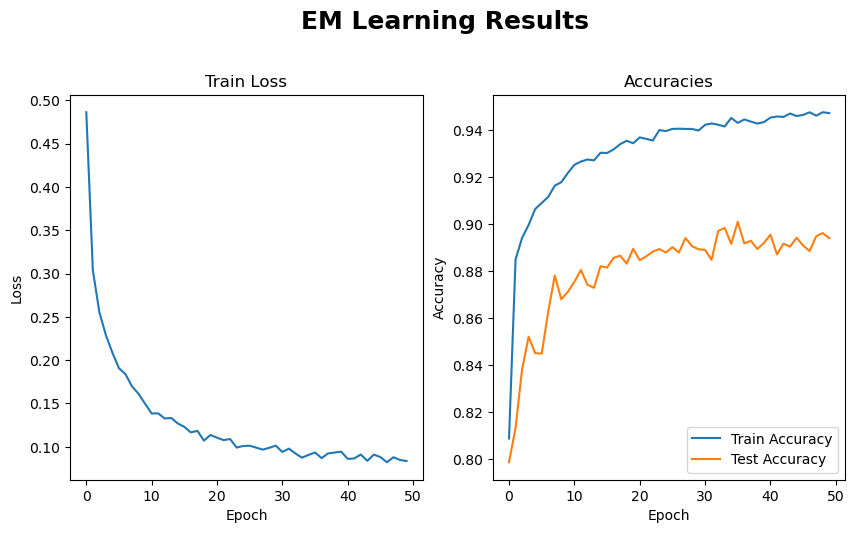

In [15]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot (Train Loss)
ax1.plot(results['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')

# Plot the second subplot (Accuracies)
ax2.plot(results['train_acc'], label='Train Accuracy')
ax2.plot(results['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
ax2.legend()

fig.suptitle('EM Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()

In [17]:
torch.mean(results['test_acc'][45:])

tensor(0.8928)